In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
birds_recep_df = sc.read.json('datos/all-birds-data.jsonlines/')
birds_recep = birds_recep_df.rdd

### Desde hace cuanto hay datos en la 3er antena

In [7]:
birds_recep.filter(lambda x: x['recep_3'] > 0).map(lambda x: x['timestamp']).min()

'2017-12-30 07:56:01'

In [5]:
FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

In [6]:
from pyspark.sql.functions import split, concat, lit

count_by_hour = birds_recep_df.withColumn('timestamp', concat(split('timestamp', ' ')[0], lit('-'),split(split('timestamp', ' ')[1], ':')[0])).groupby('tag_id', 'timestamp').count()
count_by_date = birds_recep_df.withColumn('timestamp', split('timestamp', ' ')[0]).groupby('tag_id', 'timestamp').count() 



In [7]:
df = count_by_date.toPandas()

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [9]:
df_female = df[df['tag_id'].isin(FEMALES)]
df_male = df[df['tag_id'].isin(MALES)]

In [10]:
def show_emmisions_count(df, title, y_lim=13000, x_lim0='2017-12-29', x_lim1='2018-03-10'):
    
    df1 = df[df.tag_id < 22]
    df2 = df[(df.tag_id >= 22) & (df.tag_id < 29)]
    df3 = df[(df.tag_id >= 29)]
    
    df1 = df1.pivot(index='timestamp', columns='tag_id', values='count')
    df2 = df2.pivot(index='timestamp', columns='tag_id', values='count')
    df3 = df3.pivot(index='timestamp', columns='tag_id', values='count')
    
    fig, axes = plt.subplots(nrows=3, ncols=1)
    for i in range(3):
        axes[i].axvline(pd.Timestamp(2018, 1, 10))
    fig.suptitle(title)

    df1.plot(ax=axes[0], xlim=(pd.Timestamp(x_lim0), pd.Timestamp(x_lim1)), ylim=(0,y_lim), legend=False)
    df2.plot(ax=axes[1], xlim=(pd.Timestamp(x_lim0), pd.Timestamp(x_lim1)), ylim=(0,y_lim), legend=False)
    df3.plot(ax=axes[2], xlim=(pd.Timestamp(x_lim0), pd.Timestamp(x_lim1)), ylim=(0,y_lim), legend=False)


<IPython.core.display.Javascript object>


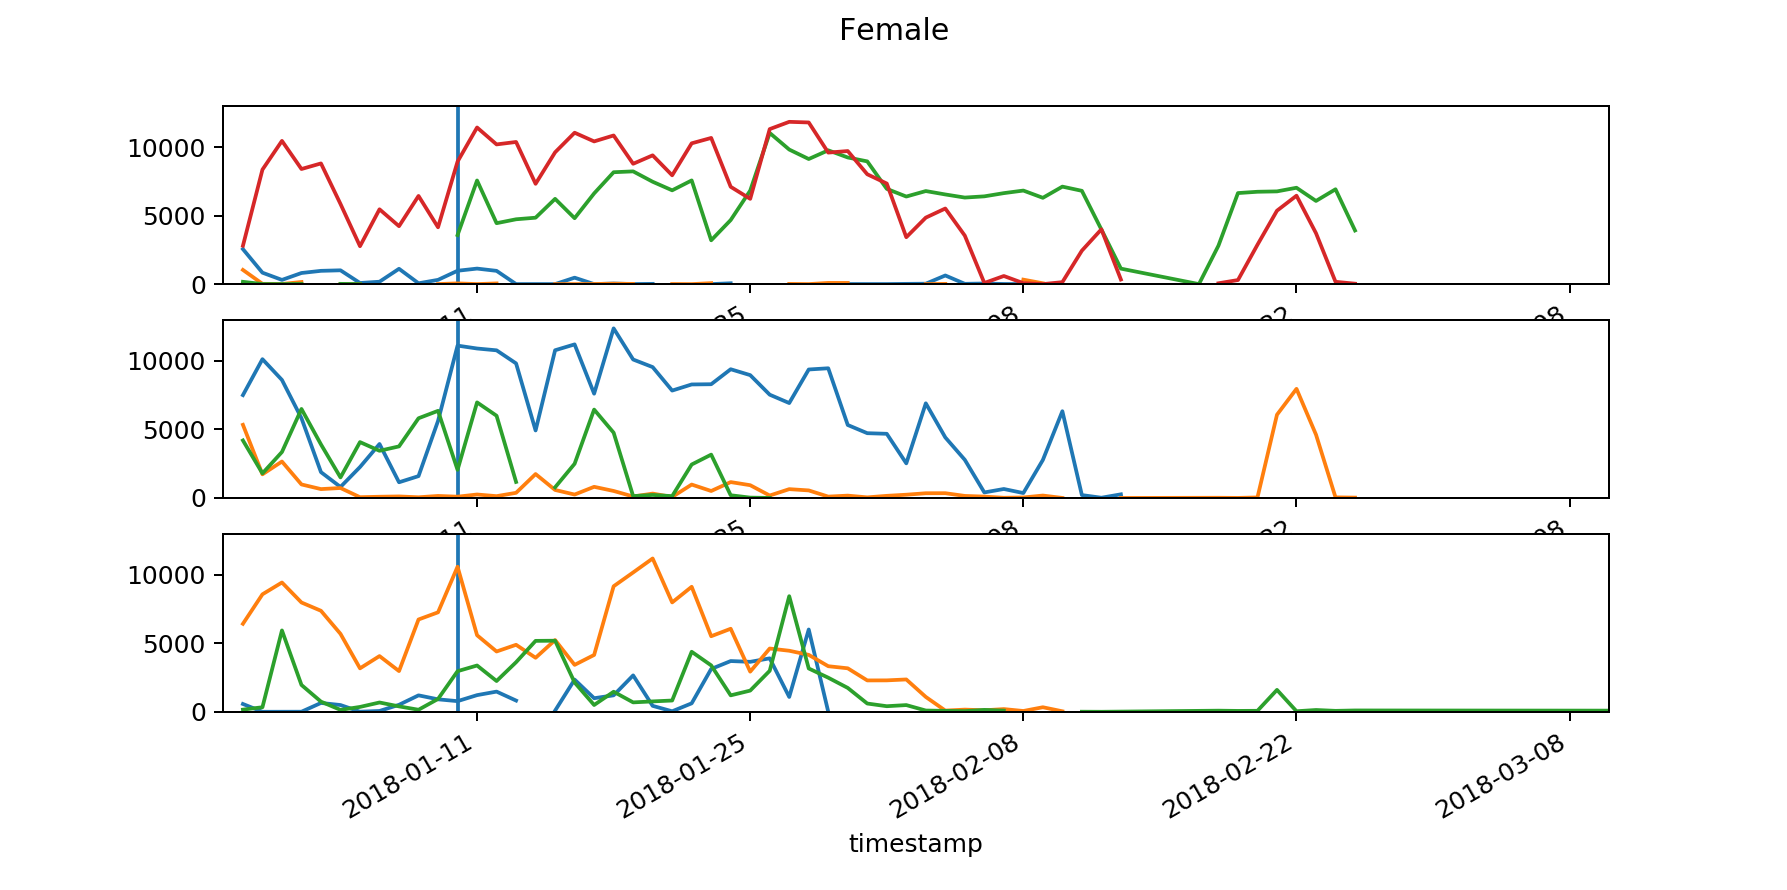

In [64]:
show_emmisions_count(df_female, 'Female')

<IPython.core.display.Javascript object>


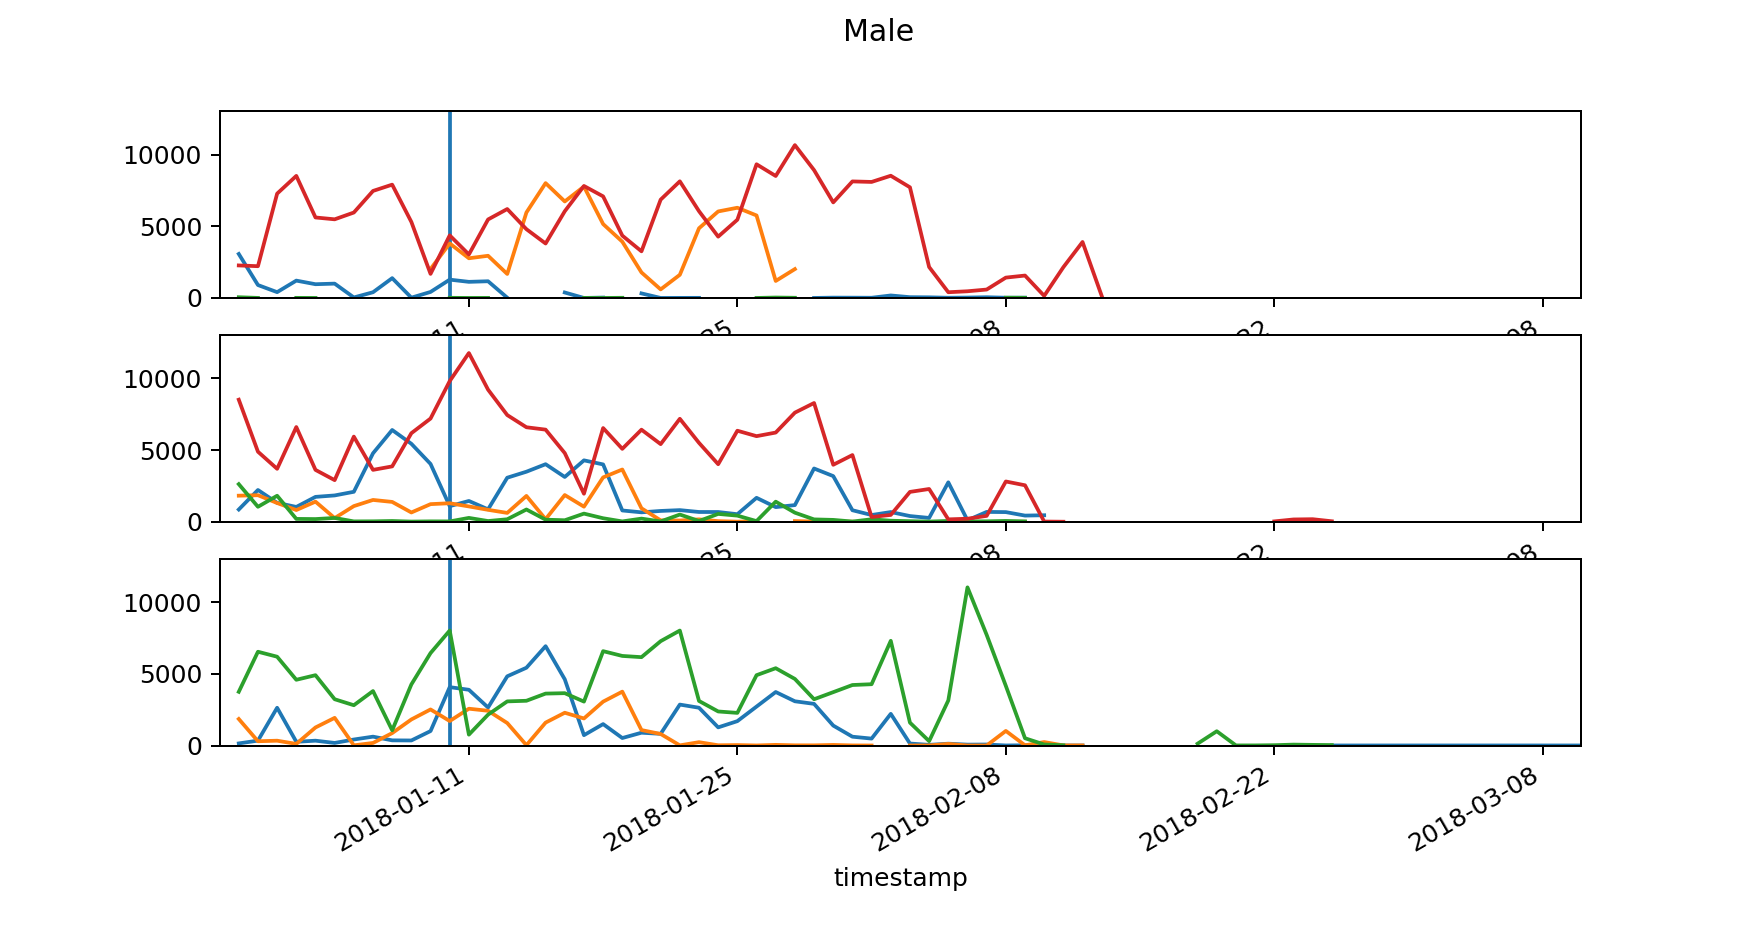

In [96]:
show_emmisions_count(df_male, 'Male')

<IPython.core.display.Javascript object>


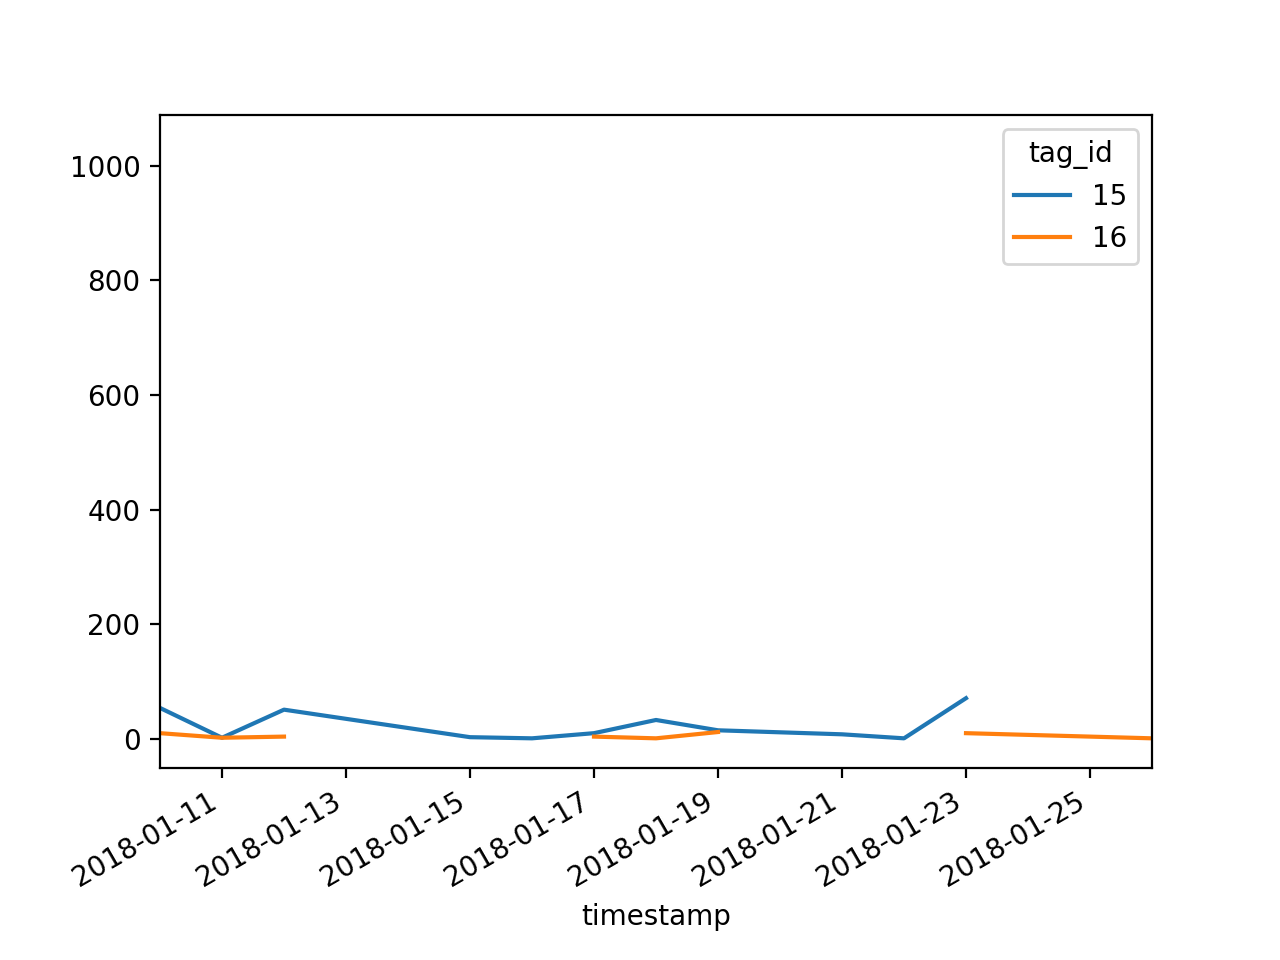

In [22]:
x_lim0='2018-01-10'
x_lim1='2018-01-26'
    
df1 = df[(df.tag_id == 15) | (df.tag_id == 16)]    
df1 = df1.pivot(index='timestamp', columns='tag_id', values='count')

fig, ax = plt.subplots()


#ax.axvline(pd.Timestamp(2018, 1, 10))

df1.plot(ax=ax, xlim=(pd.Timestamp(x_lim0), pd.Timestamp(x_lim1)), legend=True)




In [69]:
df_by_hour = count_by_hour.toPandas()

In [70]:
df_by_hour['timestamp'] = pd.to_datetime(df_by_hour['timestamp'])

In [71]:
df_h_female = df_by_hour[df_by_hour['tag_id'].isin(FEMALES)]
df_h_male = df_by_hour[df_by_hour['tag_id'].isin(MALES)]

<IPython.core.display.Javascript object>


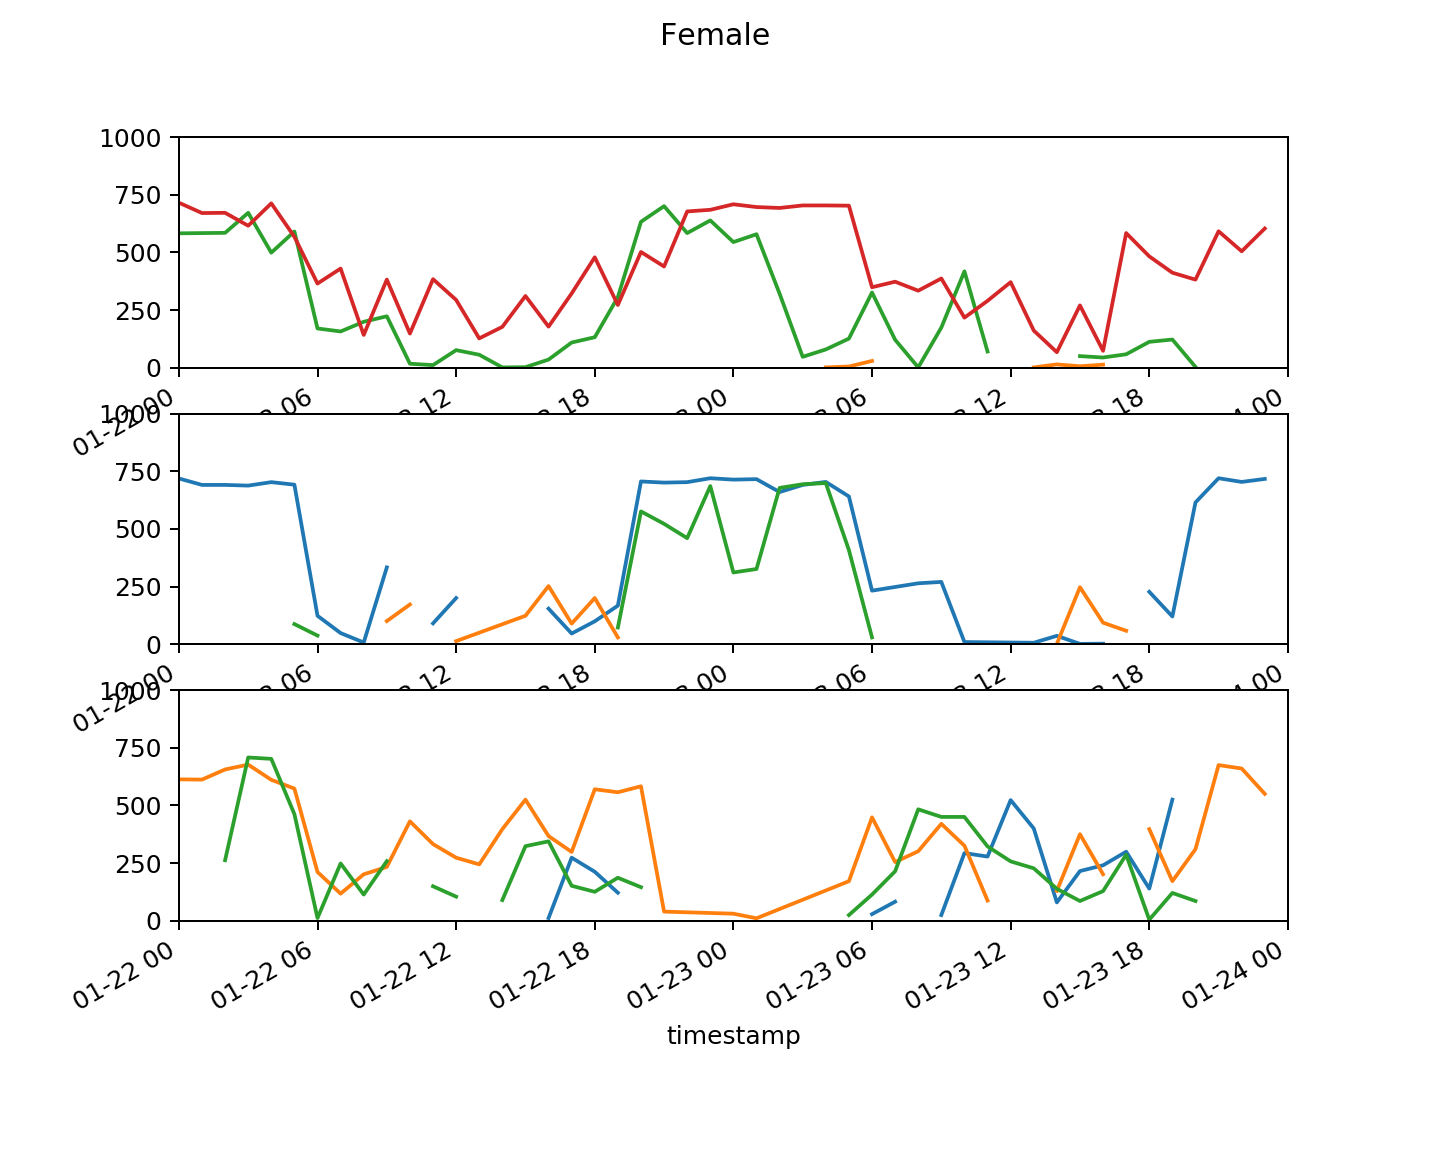

In [81]:

date_from = '2018-01-22'
date_to = '2018-01-24'
show_emmisions_count(df_h_female[(df_h_female.timestamp >= date_from) & (df_h_female.timestamp < date_to)], 'Female', 1000, date_from, date_to)



## Utils

In [7]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in FEMALES+MALES)

In [10]:
DATA_SUBSET = False
START_TIME = '08:00:00'
END_TIME = '19:00:00'
start_date = '2018-01-10'
end_date = '2018-01-26'

if DATA_SUBSET:
    birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date).filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME)

### Cantidad de recepciones por antena

#### (2) ¿Todas las antenas tienen el mismo impacto? ¿O hay antenas con más emisiones/más puntos alcanzables?

<IPython.core.display.Javascript object>


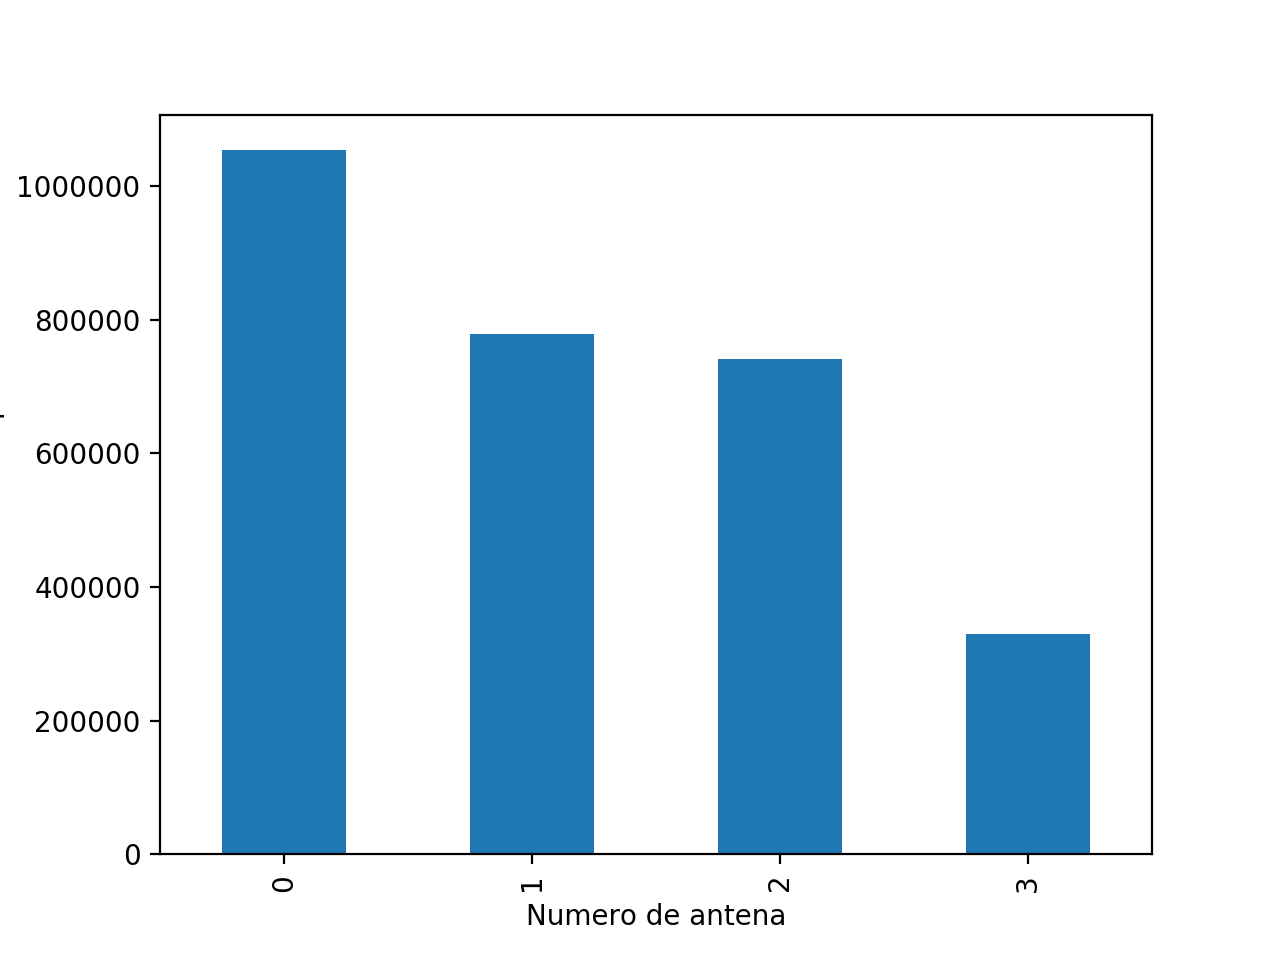

Text(0.5,0,'Numero de antena')

In [8]:
cants_recep_por_antena = []
for i in range(4):
    cant = birds_recep.filter(lambda x: x['recep_{}'.format(i)] > 0).count()
    cants_recep_por_antena.append({'antenna': i, 'cant_recep': cant})
    
p = pd.DataFrame(cants_recep_por_antena).plot.bar(x='antenna', y='cant_recep', legend=False)
p.set_ylabel('Cantidad de recepciones')
p.set_xlabel('Numero de antena')


### Cantidad de emisions que usan _x_ cantidad de antenas

#### (9) ¿Cuantos emisiones usan 1 antena? ¿Y 2 antenas?

<IPython.core.display.Javascript object>


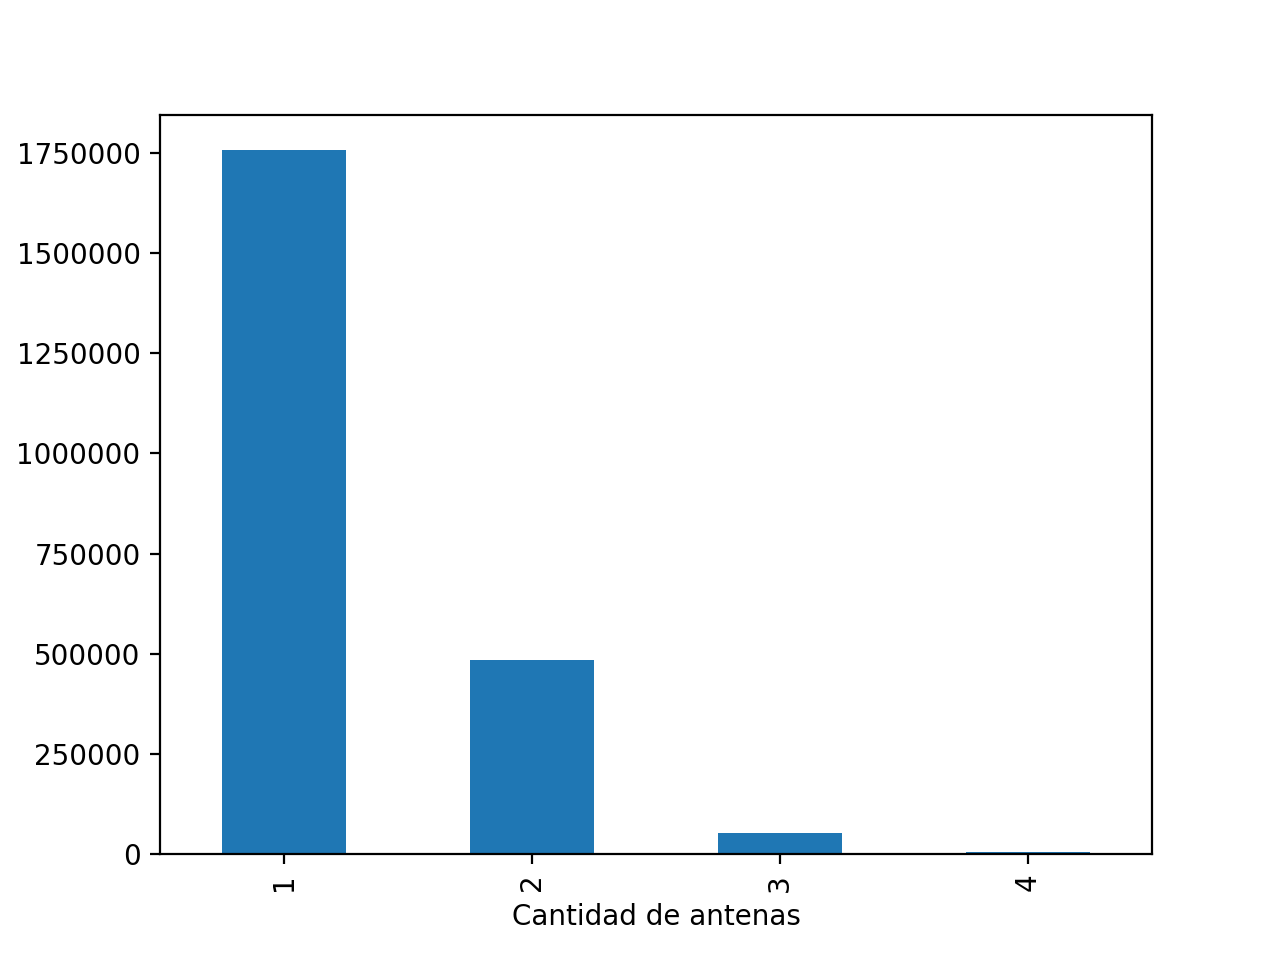

Text(0.5,0,'Cantidad de antenas')

In [9]:
cant_recep = birds_recep.groupBy(lambda x: sum([x['recep_{}'.format(i)] > 0 for i in range(4)])).map(lambda x: {'antennas': x[0],'cant_recep': len(x[1])})

p = pd.DataFrame(cant_recep.collect()).plot.bar(x='antennas', y='cant_recep', legend=False)
p.set_ylabel('Cantidad de emisiones')
p.set_xlabel('Cantidad de antenas')

## Cantidad de emisiones (es decir, agrupamiento de recepciones) por pajaro

<IPython.core.display.Javascript object>


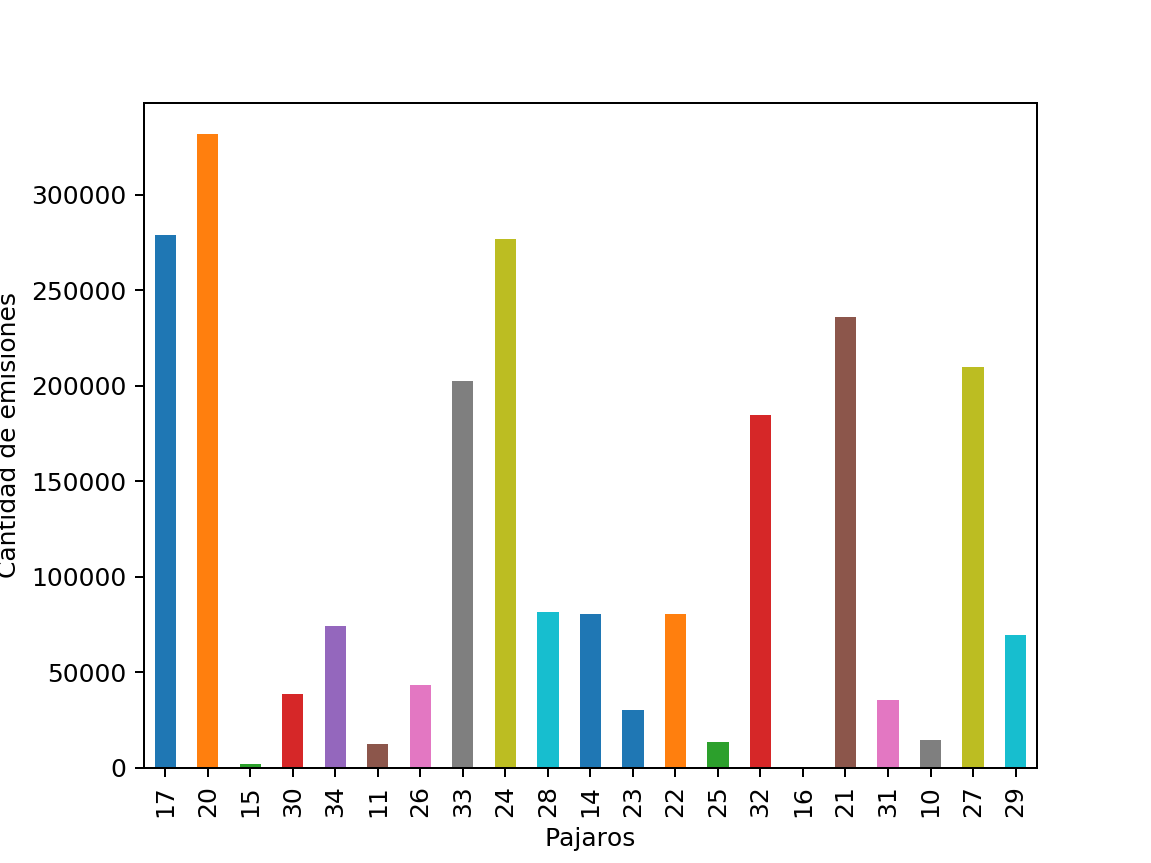

Text(0.5,0,'Pajaros')

In [13]:
cant_by_bird = (
    birds_recep
    .groupBy(lambda x: x['tag_id'])
    .map(lambda x: {'tag_id': x[0],'cant_emisiones': len(x[1])})
)

cant_by_bird_pd = pd.DataFrame(cant_by_bird.collect())
cant_by_bird_pd['gender'] = np.where(cant_by_bird_pd['tag_id'].isin(MALES), 'male', 'female')
cant_by_bird_pd = cant_by_bird_pd.sort_values(by=['gender'])
p = cant_by_bird_pd.plot.bar(x='tag_id', y='cant_emisiones', legend=False)
p.set_ylabel('Cantidad de emisiones')
p.set_xlabel('Pajaros')

### Cantidad de emisiones fuera del dormidero

<IPython.core.display.Javascript object>


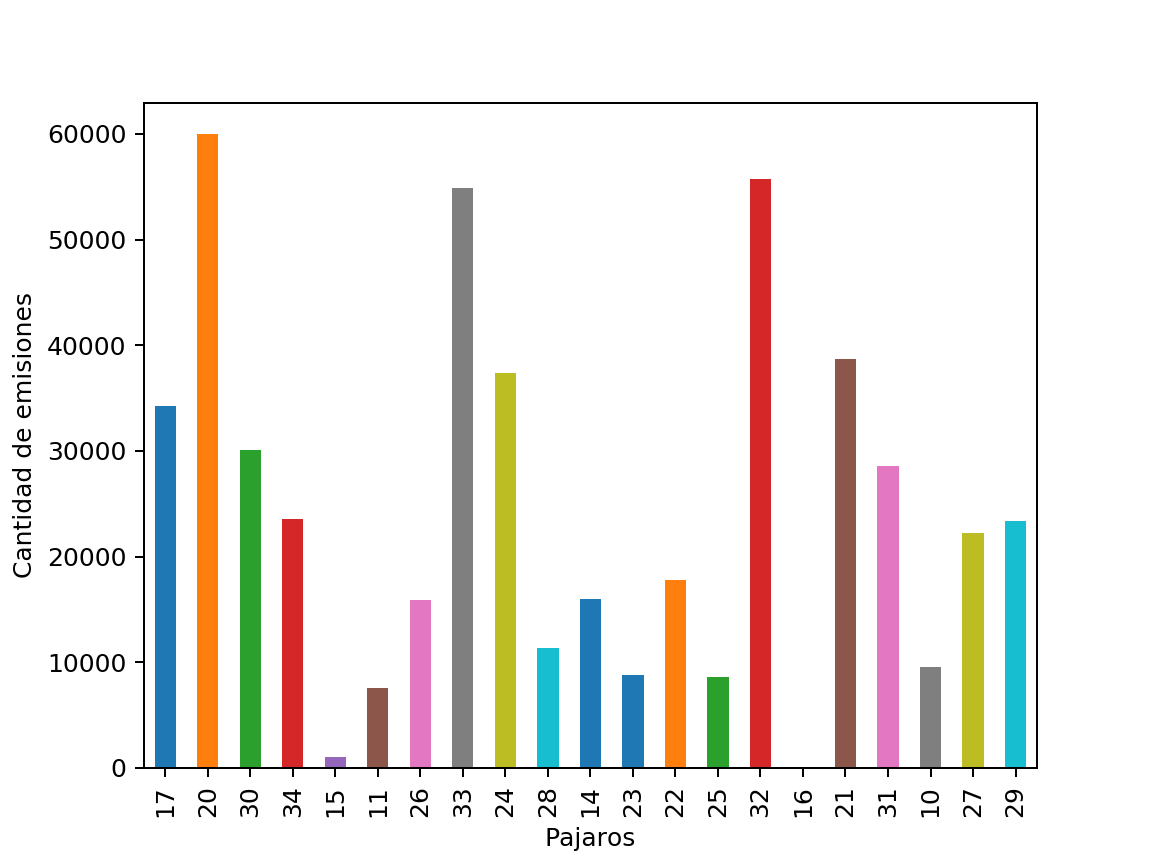

Text(0.5,0,'Pajaros')

In [14]:
cant_by_bird = (
    birds_recep
    .filter(lambda x: '09:00:00' <= x['timestamp'].split(' ')[1] <= '18:00:00')
    .groupBy(lambda x: x['tag_id'])
    .map(lambda x: {'tag_id': x[0],'cant_emisiones': len(x[1])})
)

cant_by_bird_pd = pd.DataFrame(cant_by_bird.collect())
cant_by_bird_pd['gender'] = np.where(cant_by_bird_pd['tag_id'].isin(MALES), 'male', 'female')
cant_by_bird_pd = cant_by_bird_pd.sort_values(by=['gender'])
p = cant_by_bird_pd.plot.bar(x='tag_id', y='cant_emisiones', legend=False)
p.set_ylabel('Cantidad de emisiones')
p.set_xlabel('Pajaros')